**The notebook contains image augmentations,training log for few experiments and  anchor aspect ratio box calculations based on ground truth of training dataset.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

In [2]:
import tensorflow as tf

In [7]:
%cd '/content/drive/MyDrive/new/TensorFlow/'
!git clone https://github.com/tensorflow/models.git

/content/drive/MyDrive/new/TensorFlow
fatal: destination path 'models' already exists and is not an empty directory.


**Installing TFOD Model Zoo API**

In [4]:
%cd /content/drive/MyDrive/new/TensorFlow/models/research/
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

/content/drive/MyDrive/new/TensorFlow/models/research
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/new/TensorFlow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.9 MB 6.6 MB/s 
     |████████████████████████████████| 352 kB 87.1 MB/s 
     |████████████████████████████████| 665.5 MB 21 kB/s 
     |████████████████████████████████| 1.8 MB 58.1 MB/s 
     |████████████████████████████████| 23.1 MB 489 kB/s 
     |████████████████████████████████| 1.3 MB 79.5 MB/s 
     |████████████████████████████████

**Checking the GPU Assigned**

In [ ]:
!nvidia-smi

Wed Jun 29 08:52:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Adjusting version of few libraries**

In [5]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.6.0.66.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-5896f664.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-d21001fc.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

**Testing the Installation of TFOD**

In [ ]:
!python /content/drive/MyDrive/new/TensorFlow/models/research/object_detection/builders/model_builder_tf2_test.py

Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-06-28 21:17:25.024788: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0628 21:17:25.242034 140615300016000 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.3s
I0628 21:17:25.606808 140615300016000 test_util.py:2309] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.3s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.49s
I0628 21:17:26.096823 140615300016000 test_u

**Visualization Functions**

In [14]:
def recenter_image(image):
    # ssd preprocessing
    #image += [123.68, 116.779, 103.939]
    return image

def display_instances(image, bboxes, classes):
    image = recenter_image(image)
    w, h, _ = image.shape
    # resize the bboxes
    #bboxes[:, [0, 2]] *= w
    #bboxes[:, [1, 3]] *= h

    f, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image.astype(np.uint8))

    for bb, cl in zip(bboxes, classes):
        y1, x1, y2, x2 = bb     
        rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor='r', linewidth=2)
        ax.add_patch(rec)
    plt.show()

def display_batch(batch):
    # get images, bboxes and classes
    batched_images = batch[0]['image'].numpy()
    batched_bboxes = batch[1]['groundtruth_boxes'].numpy()
    batched_classes = batch[1]['groundtruth_classes'].numpy()
    num_bboxes = batch[1]['num_groundtruth_boxes'].numpy()
    #print(batched_bboxes.shape)
    batch_size = batched_images.shape[0]
    for idx in range(batch_size):
      #print(batched_bboxes[idx, :num_bboxes[idx], :])
      display_instances(batched_images[idx, ...], batched_bboxes[idx, :num_bboxes[idx], :], batched_classes[idx, ...])


In [4]:
%cd /content/drive/MyDrive/nd013-c1-vision-starter/
label_map_path  = '/content/drive/MyDrive/nd013-c1-vision-starter/label_map.pbtxt'
config_path ='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp1/training/reference/exp1_pipeline.config'
saved_model_path = '/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp1/training/reference/exported_model/saved_model'

/content/drive/MyDrive/nd013-c1-vision-starter


In [5]:
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib import animation
from object_detection.builders.dataset_builder import build as build_dataset
from object_detection.utils.config_util import get_configs_from_pipeline_file
from object_detection.utils.label_map_util import create_category_index_from_labelmap
from object_detection.utils import visualization_utils as viz_utils
#from utils2 import get_module_logger

category_index = create_category_index_from_labelmap(label_map_path,use_display_name=True)


# open config file
#logger.info(f'Loading config from {config_path}')
configs = get_configs_from_pipeline_file(config_path)
eval_config = configs['eval_config']
eval_input_config = configs['eval_input_config']
model_config = configs['model']
tf_rec_path="/content/drive/MyDrive/nd013-c1-vision-starter/data_new/train/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord"
    # update the eval config file
eval_input_config.tf_record_input_reader.input_path[:] = [tf_rec_path]

    # build dataset
dataset = build_dataset(eval_input_config)

images = []
#logger.info(f'Inference on {tf_record_path}')

INFO:tensorflow:Reading unweighted datasets: ['/content/drive/MyDrive/nd013-c1-vision-starter/data_new/train/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/content/drive/MyDrive/nd013-c1-vision-starter/data_new/train/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


**Augmentation Adjsut gamma moves the histogram to right or left**
If gamma > 1, the histogram will shift towards left and the output image will be darker than the input image.

/content/drive/MyDrive/nd013-c1-vision-starter


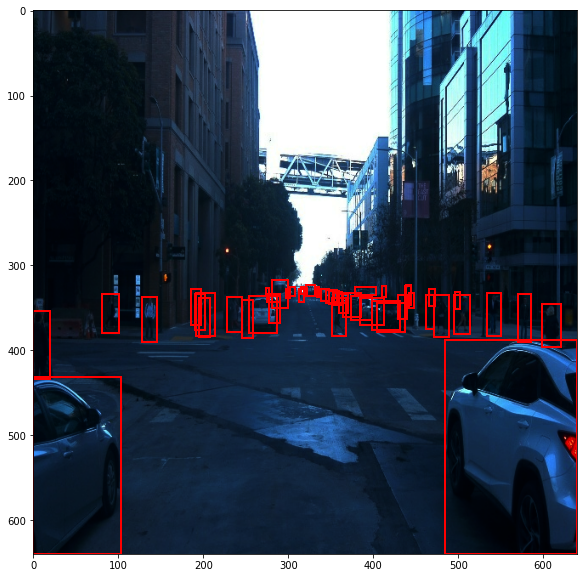

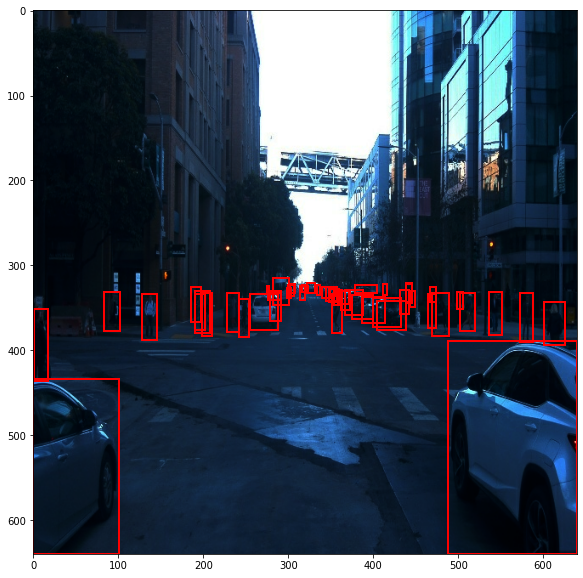

In [7]:
%cd '/content/drive/MyDrive/nd013-c1-vision-starter'
from utils2 import *
import numpy as np
from object_detection.core import standard_fields
from object_detection.metrics import coco_evaluation
from object_detection.utils import tf_version
from pycocotools import cocoeval
%matplotlib inline

def _get_categories_list():
  return [{
      'id': 1,
      'name': 'vehicle'
  }, {
      'id': 2,
      'name': 'pedestrian'
  }, {
      'id': 3,
      'name': 'dummy'
  }, {
      'id': 4,
      'name': 'cyclist'
  }]
  
coco_evaluator = coco_evaluation.CocoDetectionEvaluator(_get_categories_list(),include_metrics_per_category=False,all_metrics_per_category=False)
for idx, batch in enumerate(dataset):
  if idx < 2:
    input_tensor = batch['image']
    input_tensor=tf.image.adjust_gamma(input_tensor, 2.0)
    image_np = input_tensor.numpy().astype(np.uint8)
    input_tensor = input_tensor[tf.newaxis, ...]
    gt_bb = batch['groundtruth_boxes'].numpy()
    gt_bb=gt_bb*640
    gt_cls = batch['groundtruth_classes'].numpy()
    display_instances(image_np,gt_bb ,gt_cls)
  elif idx > 2:
    break


**Augmentation Adjust Contrast:**
Contrast was adjusted randomly betweeb 0.2 and 0.8 in the train dataset.

/content/drive/MyDrive/nd013-c1-vision-starter


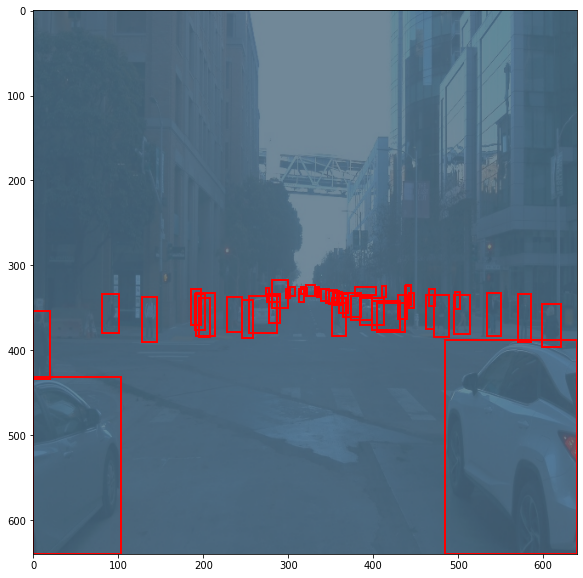

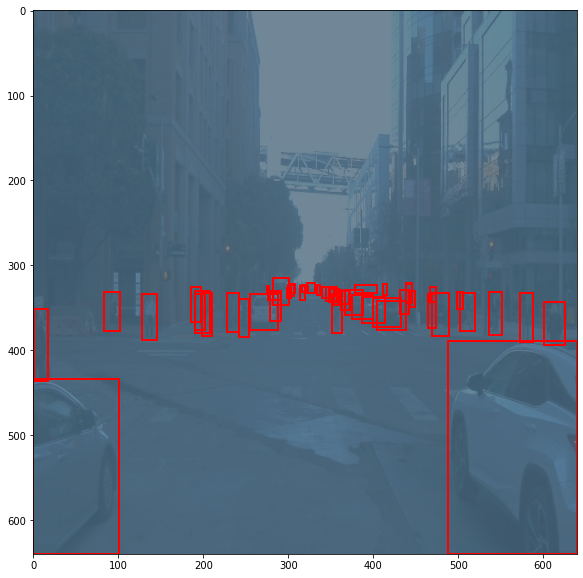

In [8]:
%cd '/content/drive/MyDrive/nd013-c1-vision-starter'
from utils2 import *
import numpy as np
from object_detection.core import standard_fields
from object_detection.metrics import coco_evaluation
from object_detection.utils import tf_version
from pycocotools import cocoeval
%matplotlib inline

def _get_categories_list():
  return [{
      'id': 1,
      'name': 'vehicle'
  }, {
      'id': 2,
      'name': 'pedestrian'
  }, {
      'id': 3,
      'name': 'dummy'
  }, {
      'id': 4,
      'name': 'cyclist'
  }]
  
coco_evaluator = coco_evaluation.CocoDetectionEvaluator(_get_categories_list(),include_metrics_per_category=False,all_metrics_per_category=False)
for idx, batch in enumerate(dataset):
  if idx < 2:
    input_tensor = batch['image']
    input_tensor=tf.image.adjust_contrast(input_tensor, .2)
    image_np = input_tensor.numpy().astype(np.uint8)
    input_tensor = input_tensor[tf.newaxis, ...]
    gt_bb = batch['groundtruth_boxes'].numpy()
    gt_bb=gt_bb*640
    gt_cls = batch['groundtruth_classes'].numpy()
    display_instances(image_np,gt_bb ,gt_cls)
  elif idx > 2:
    break


**Augmentation Center crop**

/content/drive/MyDrive/nd013-c1-vision-starter


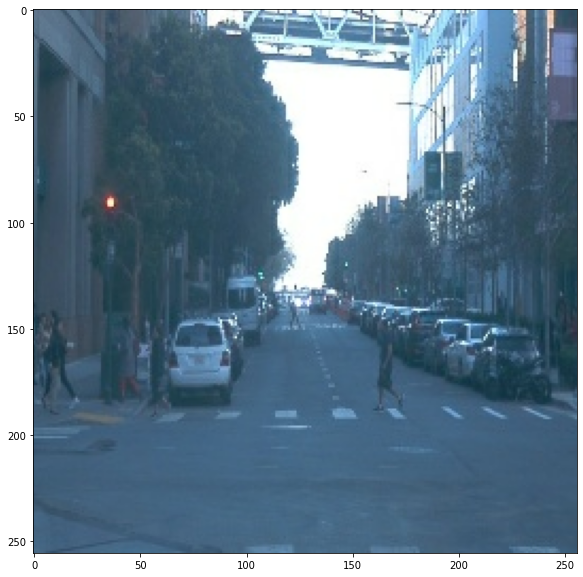

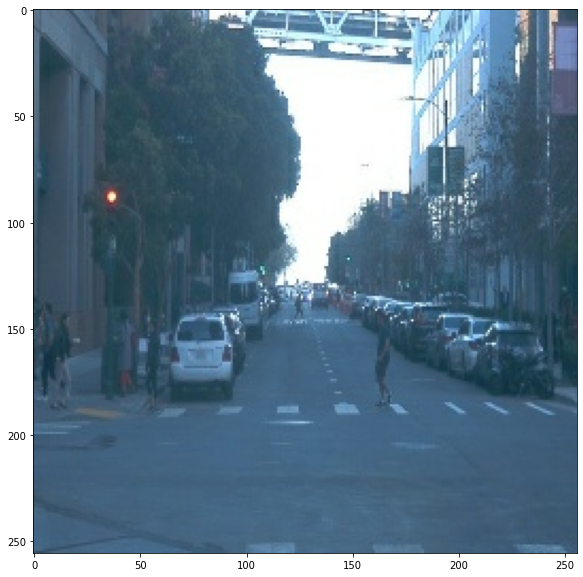

In [9]:
%cd '/content/drive/MyDrive/nd013-c1-vision-starter'
from utils2 import *
import numpy as np
from object_detection.core import standard_fields
from object_detection.metrics import coco_evaluation
from object_detection.utils import tf_version
from pycocotools import cocoeval
%matplotlib inline

def _get_categories_list():
  return [{
      'id': 1,
      'name': 'vehicle'
  }, {
      'id': 2,
      'name': 'pedestrian'
  }, {
      'id': 3,
      'name': 'dummy'
  }, {
      'id': 4,
      'name': 'cyclist'
  }]
  
coco_evaluator = coco_evaluation.CocoDetectionEvaluator(_get_categories_list(),include_metrics_per_category=False,all_metrics_per_category=False)
for idx, batch in enumerate(dataset):
  if idx < 2:
    input_tensor = batch['image']
    input_tensor=tf.image.central_crop(input_tensor, 0.4)
    image_np = input_tensor.numpy().astype(np.uint8)
    input_tensor = input_tensor[tf.newaxis, ...]
    gt_bb = batch['groundtruth_boxes'].numpy()
    gt_bb=gt_bb*640
    gt_cls = batch['groundtruth_classes'].numpy()
    display_instances(image_np,gt_bb ,gt_cls)
  elif idx > 2:
    break


In [ ]:
#exp5 training
!python '/content/drive/MyDrive/nd013-c1-vision-starter/experiments/model_main_tf2.py'  --model_dir='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp5/training/reference' --pipeline_config_path='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp5/training/reference/exp5_pipeline.config'

2022-07-01 00:15:37.764247: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0701 00:15:37.768583 140713371092864 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0701 00:15:37.779561 140713371092864 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0701 00:15:37.779745 140713371092864 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0701 00:15:37.928652 140713371092864 deprecation.py:347] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experiment

In [ ]:
#exp6 training
!python '/content/drive/MyDrive/nd013-c1-vision-starter/experiments/model_main_tf2.py'  --model_dir='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp6/training/reference' --pipeline_config_path='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp6/training/reference/exp6_pipeline.config'

2022-07-01 03:15:01.064993: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0701 03:15:01.068864 140376825550720 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0701 03:15:01.079972 140376825550720 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0701 03:15:01.080177 140376825550720 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0701 03:15:01.238133 140376825550720 deprecation.py:347] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experiment

In [ ]:
#exp7 training
!python '/content/drive/MyDrive/nd013-c1-vision-starter/experiments/model_main_tf2.py'  --model_dir='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp7/training/reference' --pipeline_config_path='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp7/training/reference/exp7_pipeline.config'

2022-07-01 12:15:42.315298: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0701 12:15:42.318816 140604879042432 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0701 12:15:42.329374 140604879042432 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0701 12:15:42.329529 140604879042432 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0701 12:15:42.469609 140604879042432 deprecation.py:347] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experiment

In [ ]:
#exp8 training
!python '/content/drive/MyDrive/nd013-c1-vision-starter/experiments/model_main_tf2.py'  --model_dir='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp8/training/reference' --pipeline_config_path='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp8/training/reference/exp8_pipeline.config'

2022-07-01 15:18:22.486358: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0701 15:18:22.490287 139976446379904 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0701 15:18:22.502784 139976446379904 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0701 15:18:22.502946 139976446379904 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0701 15:18:22.644481 139976446379904 deprecation.py:347] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experiment

In [ ]:
#Export exp8  model
%cd /content/drive/MyDrive/nd013-c1-vision-starter/experiments/
pipeline_config_path= '/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp8/training/reference/exp8_pipeline.config'
ckpt_dir='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp8/training/reference/'
exported_model='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp8/training/reference/exported_model/'
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path {pipeline_config_path} --trained_checkpoint_dir {ckpt_dir} --output_directory {exported_model}

/content/drive/MyDrive/nd013-c1-vision-starter/experiments
2022-07-01 17:56:22.169486: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0701 17:56:22.331588 139784734828416 deprecation.py:619] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:464: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradie

**Evaluate model**

In [ ]:
#exp8
%cd /content/drive/MyDrive/nd013-c1-vision-starter/
label_map_path  = '/content/drive/MyDrive/nd013-c1-vision-starter/label_map.pbtxt'
config_path ='/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp8/training/reference/exp8_pipeline.config'
saved_model_path = '/content/drive/MyDrive/nd013-c1-vision-starter/experiments/exp8/training/reference/exported_model/saved_model'

/content/drive/MyDrive/nd013-c1-vision-starter


Training Exp2 result is available at
https://tensorboard.dev/experiment/VDHlQvIMSyuRjjJVcBPBOg/#scalars

**Build Dataset**

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib import animation
from object_detection.builders.dataset_builder import build as build_dataset
from object_detection.utils.config_util import get_configs_from_pipeline_file
from object_detection.utils.label_map_util import create_category_index_from_labelmap
from object_detection.utils import visualization_utils as viz_utils
#from utils2 import get_module_logger

category_index = create_category_index_from_labelmap(label_map_path,use_display_name=True)

# Load saved model and build the detection function
#logger.info(f'Loading model from {saved_model_path}')
detect_fn = tf.saved_model.load(saved_model_path)

# open config file
#logger.info(f'Loading config from {config_path}')
configs = get_configs_from_pipeline_file(config_path)
eval_config = configs['eval_config']
eval_input_config = configs['eval_input_config']
model_config = configs['model']
#tf_rec_path="/content/drive/MyDrive/nd013-c1-vision-starter/data_new/train/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord"
    # update the eval config file
#eval_input_config.tf_record_input_reader.input_path[:] = [tf_rec_path]

    # build dataset
dataset = build_dataset(eval_input_config)

images = []
#logger.info(f'Inference on {tf_record_path}')

INFO:tensorflow:Reading unweighted datasets: ['/content/drive/MyDrive/nd013-c1-vision-starter/data_new/eval/segment-3132521568089292927_2220_000_2240_000_with_camera_labels.tfrecord', '/content/drive/MyDrive/nd013-c1-vision-starter/data_new/eval/segment-4013698638848102906_7757_240_7777_240_with_camera_labels.tfrecord', '/content/drive/MyDrive/nd013-c1-vision-starter/data_new/eval/segment-4138614210962611770_2459_360_2479_360_with_camera_labels.tfrecord', '/content/drive/MyDrive/nd013-c1-vision-starter/data_new/eval/segment-4277109506993614243_1648_000_1668_000_with_camera_labels.tfrecord', '/content/drive/MyDrive/nd013-c1-vision-starter/data_new/eval/segment-4292360793125812833_3080_000_3100_000_with_camera_labels.tfrecord', '/content/drive/MyDrive/nd013-c1-vision-starter/data_new/eval/segment-4295449061847708198_3769_000_3789_000_with_camera_labels.tfrecord', '/content/drive/MyDrive/nd013-c1-vision-starter/data_new/eval/segment-4305539677513798673_2200_000_2220_000_with_camera_labels

In [ ]:
%cd '/content/drive/MyDrive/nd013-c1-vision-starter'
from utils2 import *
import numpy as np
from object_detection.core import standard_fields
from object_detection.metrics import coco_evaluation
from object_detection.utils import tf_version
from pycocotools import cocoeval

def _get_categories_list():
  return [{
      'id': 1,
      'name': 'vehicle'
  }, {
      'id': 2,
      'name': 'pedestrian'
  }, {
      'id': 3,
      'name': 'dummy'
  }, {
      'id': 4,
      'name': 'cyclist'
  }]
  
coco_evaluator = coco_evaluation.CocoDetectionEvaluator(_get_categories_list(),include_metrics_per_category=False,all_metrics_per_category=False)
for idx, batch in enumerate(dataset):
  input_tensor = batch['image']
  image_np = input_tensor.numpy().astype(np.uint8)
  input_tensor = input_tensor[tf.newaxis, ...]
  detections_batch = detect_fn(input_tensor)
  gt_bb = batch['groundtruth_boxes'].numpy()
  gt_bb=gt_bb*640
  gt_cls = batch['groundtruth_classes'].numpy()
  coco_evaluator.add_single_ground_truth_image_info(
      image_id=str(idx),
      groundtruth_dict={
          standard_fields.InputDataFields.groundtruth_boxes:
          gt_bb,
          standard_fields.InputDataFields.groundtruth_classes: gt_cls
      })
  num_det = detections_batch['detection_boxes'].numpy().shape[1]
  dt_bb = np.reshape(detections_batch['detection_boxes'].numpy(),(num_det,4))
  dt_bb=dt_bb*640
  dt_bb_cls = np.reshape(detections_batch['detection_classes'].numpy(),num_det)
  dt_bb_scores = np.reshape(detections_batch['detection_scores'].numpy(),(num_det))
  coco_evaluator.add_single_detected_image_info(
      image_id=str(idx),
      detections_dict={
          standard_fields.DetectionResultFields.detection_boxes:
          dt_bb,
          standard_fields.DetectionResultFields.detection_scores:
          dt_bb_scores,
          standard_fields.DetectionResultFields.detection_classes:
          dt_bb_cls
      })

/content/drive/MyDrive/nd013-c1-vision-starter


**Anchor box aspect ratio calculation from ground truth of train dataset**

In [ ]:
from object_detection.core import standard_fields
from object_detection.metrics import coco_evaluation
from object_detection.utils import tf_version
#from pycocotools import cocoeval
def _get_categories_list():
  return [{
      'id': 1,
      'name': 'vehicle'
  }, {
      'id': 2,
      'name': 'pedestrian'
  }, {
      'id': 3,
      'name': 'dummy'
  }, {
      'id': 4,
      'name': 'cyclist'
  }]

coco_evaluator = coco_evaluation.CocoDetectionEvaluator(_get_categories_list(),include_metrics_per_category=True,all_metrics_per_category=True)
a_ratios_i = []
a_ratios_m = []
a_ratios_l = []
l_sum=0
w_sum=0
cars=0
peds=0
bcyc=0
for idx, batch in enumerate(dataset):
  #print("Index:",idx)
  #print("\n")
  input_tensor = batch['image']
  image_np = input_tensor.numpy().astype(np.uint8)
  input_tensor = input_tensor[tf.newaxis, ...]
  #detections_batch = detect_fn(input_tensor)
  #gt_bb = example['groundtruth_boxes'].numpy()
  gt_bb = batch['groundtruth_boxes'].numpy()
  gt_bb_cal = gt_bb*640
  l = gt_bb_cal[:,2] - gt_bb_cal[:,0]
  
  l_sum+=l.shape[0]
  #print("\n")
  #print("not small length",l[l[:]>128].shape[0])
  w = gt_bb_cal[:,3] - gt_bb_cal[:,1]
  p=l*w

  s_i=p<32*32
  s_l=p>96*96
  s_m=~(s_i+s_l)

  w_sum+=w.shape[0]

  a_i=w[s_i]/l[s_i]
  a_m=w[s_m]/l[s_m]
  a_l=w[s_l]/l[s_l]
  a_ratios_i=np.concatenate((a_ratios_i,a_i),axis=0)
  a_ratios_m=np.concatenate((a_ratios_m,a_m),axis=0)
  a_ratios_l=np.concatenate((a_ratios_l,a_l),axis=0)

  gt_cls = batch['groundtruth_classes'].numpy()
  cars+=gt_cls[gt_cls[:]==1].shape[0]
  peds+=gt_cls[gt_cls[:]==2].shape[0]
  bcyc+=gt_cls[gt_cls[:]==4].shape[0]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Anchor box Aspect ratio calculation using k means clustering**

In [ ]:
from sklearn.cluster import KMeans
def get_centers(a_ratios,n_clusters):
  a=a_ratios.reshape(-1, 1)
  kmeans = KMeans(n_clusters=n_clusters)
  kmeans.fit(a)
  y_kmeans = kmeans.predict(a)
  return kmeans.cluster_centers_

In [ ]:
%matplotlib inline
def plot_elbow(a_ratios):
  from sklearn.cluster import KMeans
  a=a_ratios.reshape(-1, 1)
  # step 1
  sse = {} 
  for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000, random_state = 1).fit(a)
    sse[k] = kmeans.inertia_     # Use inertia attribute from the clustering object and store the inertia value for that K

    # step 3
  plt.figure()

  plt.plot(list(sse.keys()), list(sse.values()), 'bx-')

  plt.xlabel("Number of cluster")

  plt.ylabel("SSE")

  plt.show()

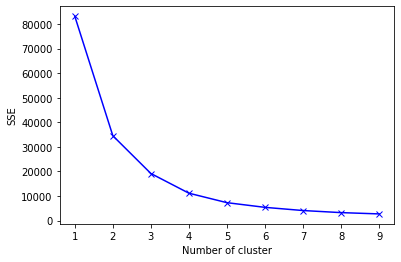

In [ ]:
plot_elbow(a_ratios_i)

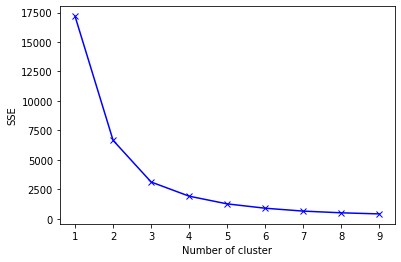

In [ ]:
plot_elbow(a_ratios_ml)

In [ ]:
a_ratios_i.shape

(257079,)

In [ ]:
a_ratios_m.shape

(59503,)

In [ ]:
a_ratios_l.shape

(13956,)

In [ ]:
get_centers(a_ratios_i,3)

array([[0.36747105],
       [2.10131595],
       [0.92024343]])

In [ ]:
get_centers(a_ratios_i,4)

array([[0.86450212],
       [1.70103675],
       [3.30941172],
       [0.35459628]])

In [ ]:
get_centers(a_ratios_ml,3)

array([[0.93661584],
       [0.38132204],
       [1.79299923]])

In [ ]:
#train
get_centers(a_ratios_m)

array([[0.88732866],
       [1.44182089],
       [0.34088771],
       [2.15626156]])

In [ ]:
get_centers(a_ratios_l)

array([[1.86339153],
       [0.7869377 ],
       [0.39347244],
       [1.0701325 ]])

In [ ]:
#train
get_centers(a_ratios_i,4)

array([[0.86519479],
       [3.29834066],
       [0.35524503],
       [1.70019481]])

In [ ]:
a_ratios_ml=np.concatenate((a_ratios_l,a_ratios_m),axis=0)

In [ ]:
get_centers(a_ratios_l)

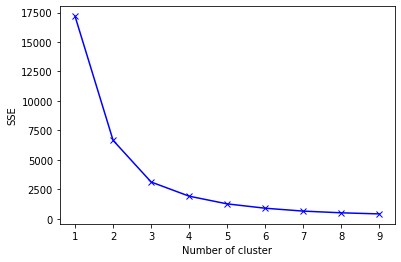

In [ ]:
from sklearn.cluster import KMeans
a=a_ratios_ml.reshape(-1, 1)
# step 1
sse = {} 
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000, random_state = 1).fit(a)
    sse[k] = kmeans.inertia_     # Use inertia attribute from the clustering object and store the inertia value for that K

# step 3
plt.figure()

plt.plot(list(sse.keys()), list(sse.values()), 'bx-')

plt.xlabel("Number of cluster")

plt.ylabel("SSE")

plt.show()

In [ ]:
get_centers(a_ratios_l)

array([[0.92576796],
       [1.82724868],
       [0.47883962]])